In [9]:
import pandas as pd
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# word by freq 
# wordcloud


/opt/homebrew/lib/python3.10/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [14]:
import pandas as pd
import numpy as np 
import re

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shawnteo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [3]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
#!pip install pyLDAvis

In [16]:
df = pd.read_csv('combined_hwz.csv', names=['Drop','ThreadName', 'ThreadLink', 'User','UserLink','Rank','Date','text']) 
df.head() #Filter by dates and then keep text?

df = df[["Date","text"]]

df["Year"] = df["Date"].str.split("-").str[2]

# drop 
# groupby year 
# LDA 
# bert 

In [17]:
df["Year"].value_counts()

20    64600
17    51584
18    38821
19    37440
21    36761
16    25251
22    15182
14    13625
13    10549
15    10218
12     5048
11     1960
09     1292
10      857
08      493
07      409
05      396
04      336
06      301
03      125
Name: Year, dtype: int64

In [18]:
df_assigned = df

In [19]:
df_assigned = df_assigned.reset_index(drop=True)

# Data cleaning

In [8]:
# Remove non-English words

# remove punc 
df_assigned['clean_text']  = df_assigned['text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))
# lower case
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: x.lower())
# tokenize
df_assigned['clean_text']  = [word_tokenize(row) for row in df_assigned['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: remove_stopwords(x))


In [9]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df_assigned['clean_text'] = df_assigned['clean_text'].apply(lambda x: lemmatization(x))


df_assigned.head()

Date                                               text  \
0  28-Dec-21  In reference to the above scenario. If I'm buy...   
1  28-Dec-21  Pls refer to page 19.\n2nd last post which I p...   
2  31-Dec-21  Hi, some questions that i need help with again...   
3  31-Dec-21  1. EHG take into account your past 12 months c...   
4  31-Dec-21  vinz said:\n1. EHG take into account your past...   

                                          clean_text  
0  [reference, scenario, buying, resale, scheme, ...  
1  [page, 2nd, post, answer, question, u, answer,...  
2  [question, help, measure, email, housing, loan...  
3  [ehg, take, account, month, income, average, m...  
4  [vinz, ehg, take, account, month, income, aver...

In [10]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df_assigned['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '

description_str

'reference scenario buying resale scheme grant year bto wife bto sell resale bto completion scheme resale mop page 2nd post answer question u answer question question help measure email housing loan amount letter action change circumstance circumstance increase salary jan housing loan day resale liking exercise housing grant increment ehg increment base month salary salary increment ehg timeline grant cpf submission resale application submission resale application hdb money appointment hdb transaction price timeline hdb loan question price budgeting loan house valuation cov way calculation house cash cov ehg grant family grant time resale buyer 20k proximity 625k 90k cpf valuation ltv bank loan translate 525k meaning bank loan 525k fork cash pay house 750k house valuation cash 90k cpf 75k grant 525k loan ehg take account month income average month u submit purchase system grant cpf grant downpayment stamp fee stamp fee unit cpf cash appointment date calculation u stamp fee fee cover 52

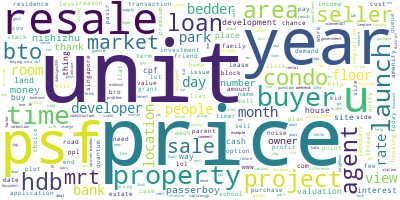

In [11]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_image()

# Topic Modeling for Text


## Create Corpus 

In [12]:
data_lemmatized = df_assigned['clean_text'].tolist()
print(data_lemmatized[:10])

[['reference', 'scenario', 'buying', 'resale', 'scheme', 'grant', 'year', 'bto', 'wife', 'bto', 'sell', 'resale', 'bto', 'completion', 'scheme', 'resale', 'mop'], ['page', '2nd', 'post', 'answer', 'question', 'u', 'answer', 'question'], ['question', 'help', 'measure', 'email', 'housing', 'loan', 'amount', 'letter', 'action', 'change', 'circumstance', 'circumstance', 'increase', 'salary', 'jan', 'housing', 'loan', 'day', 'resale', 'liking', 'exercise', 'housing', 'grant', 'increment', 'ehg', 'increment', 'base', 'month', 'salary', 'salary', 'increment', 'ehg', 'timeline', 'grant', 'cpf', 'submission', 'resale', 'application', 'submission', 'resale', 'application', 'hdb', 'money', 'appointment', 'hdb', 'transaction', 'price', 'timeline', 'hdb', 'loan', 'question', 'price', 'budgeting', 'loan', 'house', 'valuation', 'cov', 'way', 'calculation', 'house', 'cash', 'cov', 'ehg', 'grant', 'family', 'grant', 'time', 'resale', 'buyer', '20k', 'proximity', '625k', '90k', 'cpf', 'valuation', 'ltv'

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [14]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'bto'), (1, 'buying'), (2, 'completion'), (3, 'grant'), (4, 'mop'), (5, 'reference'), (6, 'resale'), (7, 'scenario'), (8, 'scheme'), (9, 'sell'), (10, 'wife'), (11, 'year'), (12, '2nd'), (13, 'answer'), (14, 'page'), (15, 'post'), (16, 'question'), (17, 'u'), (18, '20k'), (19, '525k'), (20, '625k'), (21, '750k'), (22, '75k'), (23, '90k'), (24, 'action'), (25, 'amount'), (26, 'application'), (27, 'appointment'), (28, 'bank'), (29, 'base'), (30, 'budgeting'), (31, 'buyer'), (32, 'calculation'), (33, 'cash'), (34, 'change'), (35, 'circumstance'), (36, 'cov'), (37, 'cpf'), (38, 'day'), (39, 'ehg'), (40, 'email'), (41, 'exercise'), (42, 'family'), (43, 'fork'), (44, 'hdb'), (45, 'help'), (46, 'house'), (47, 'housing'), (48, 'increase'), (49, 'increment')]

Total Vocabulary Size: 11361


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [15]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [16]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.5350533512031135
Perplexity Score:  -7.1833433739789205

topic number:  3
Coherence Score:  0.5528222590095853
Perplexity Score:  -7.154320359899548

topic number:  4
Coherence Score:  0.6009767067419436
Perplexity Score:  -7.15013391341478

topic number:  5
Coherence Score:  0.5948533623178649
Perplexity Score:  -7.165076644849161

topic number:  6
Coherence Score:  0.6173125060271694
Perplexity Score:  -7.226196240416087

topic number:  7
Coherence Score:  0.5915968045901223
Perplexity Score:  -7.264023766169824

topic number:  8
Coherence Score:  0.5925535327628422
Perplexity Score:  -7.303090528871812

topic number:  9
Coherence Score:  0.5438294886326466
Perplexity Score:  -7.391139548473127

topic number:  10
Coherence Score:  0.533900019611962
Perplexity Score:  -7.610684145486125

topic number:  11
Coherence Score:  0.48833044926737373
Perplexity Score:  -7.837746586452865

topic number:  12
Coherence Score:  0.5647092803604087
Perplexity Sc

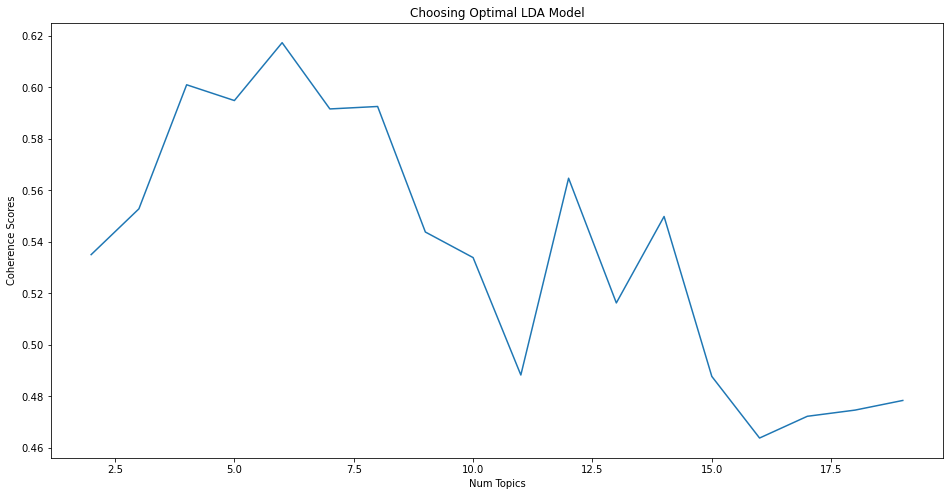

In [17]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [18]:
ntopics_des_name = 5

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [19]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.048*"property" + 0.048*"year" + 0.025*"loan" + 0.016*"cpf" + 0.015*"bank" '
  '+ 0.015*"interest" + 0.014*"rate" + 0.013*"cash" + 0.013*"money" + '
  '0.013*"hdb"'),
 (1,
  '0.022*"house" + 0.018*"place" + 0.016*"room" + 0.015*"kid" + 0.015*"parent" '
  '+ 0.014*"m" + 0.012*"family" + 0.012*"condo" + 0.011*"owner" + '
  '0.010*"work"'),
 (2,
  '0.045*"agent" + 0.044*"u" + 0.039*"unit" + 0.028*"buyer" + 0.019*"floor" + '
  '0.014*"seller" + 0.014*"time" + 0.014*"price" + 0.010*"nishizhu" + '
  '0.009*"view"'),
 (3,
  '0.034*"price" + 0.025*"psf" + 0.021*"unit" + 0.020*"launch" + 0.017*"area" '
  '+ 0.014*"project" + 0.013*"mrt" + 0.012*"condo" + 0.011*"year" + '
  '0.011*"developer"'),
 (4,
  '0.051*"bto" + 0.033*"resale" + 0.028*"hdb" + 0.025*"unit" + 0.022*"seller" '
  '+ 0.019*"flat" + 0.016*"room" + 0.016*"number" + 0.016*"time" + '
  '0.014*"valuation"')]


In [20]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [22]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df_assigned)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [24]:
df_assigned['Topic'] = topic_num

In [25]:
df_assigned

Date                                               text  \
0      28-Dec-21  In reference to the above scenario. If I'm buy...   
1      28-Dec-21  Pls refer to page 19.\n2nd last post which I p...   
2      31-Dec-21  Hi, some questions that i need help with again...   
3      31-Dec-21  1. EHG take into account your past 12 months c...   
4      31-Dec-21  vinz said:\n1. EHG take into account your past...   
...          ...                                                ...   
36756   1-Jan-21  Dusky01 said:\nFar East a lot of such unsold T...   
36757   1-Jan-21  messi1986 said:\nWhich project? How to search?...   
36758   1-Jan-21                           Faster buy freehold ones   
36759   1-Jan-21  Bto takes 2027 to complete. So now is the time...   
36760   1-Jan-21  Move done and here's a quick review of Cube Mo...   

                                              clean_text            Topic  
0      [reference, scenario, buying, resale, scheme, ...  [4, 0, 1, 3, 2]  
1      [page, 2nd, post, answer, question, u, answer,...  [4, 2, 0, 1, 3]  
2      [question, help, measure, email, housing, loan...        [4, 0, 2]  
3      [ehg, take, account, month, income, average, m...           [0, 4]  
4      [vinz, ehg, take, account, month, income, aver...     [0, 4, 1, 2]  
...                                                  ...              ...  
36756        [dusky01, east, lot, unit, project, search]  [3, 1, 2, 4, 0]  
36757  [project, search, https, www, fareast, com, re...  [3, 2, 4, 0, 1]  
36758                                              [one]  [2, 3, 0, 1, 4]  
36759                                        [bto, time]  [4, 2, 1, 0, 3]  
36760  [move, review, cube, mover, communication, spe...     [1, 4, 3, 2]  

[36761 rows x 4 columns]

In [27]:
des_name_final = df_assigned[['Date', 'text', 'clean_text', 'Topic']]
des_name_final.head()

Date                                               text  \
0  28-Dec-21  In reference to the above scenario. If I'm buy...   
1  28-Dec-21  Pls refer to page 19.\n2nd last post which I p...   
2  31-Dec-21  Hi, some questions that i need help with again...   
3  31-Dec-21  1. EHG take into account your past 12 months c...   
4  31-Dec-21  vinz said:\n1. EHG take into account your past...   

                                          clean_text            Topic  
0  [reference, scenario, buying, resale, scheme, ...  [4, 0, 1, 3, 2]  
1  [page, 2nd, post, answer, question, u, answer,...  [4, 2, 0, 1, 3]  
2  [question, help, measure, email, housing, loan...        [4, 0, 2]  
3  [ehg, take, account, month, income, average, m...           [0, 4]  
4  [vinz, ehg, take, account, month, income, aver...     [0, 4, 1, 2]

In [28]:
des_name_final.to_csv('description_name_features_final_all_noun.csv', index=False) 

### Model Evaluation

In [29]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.180072701202405
Coherence Score:  0.5974584658742875


## Visualisation

In [32]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.208247  0.099917       1        1  36.526767
2     -0.163079 -0.078602       2        1  19.099211
0      0.050386  0.234997       3        1  18.094537
4      0.020101 -0.260945       4        1  15.135892
1      0.300839  0.004633       5        1  11.143593, topic_info=         Term         Freq        Total Category  logprob  loglift
0         bto  5098.000000  5098.000000  Default  30.0000  30.0000
273     agent  5745.000000  5745.000000  Default  29.0000  29.0000
263  property  7016.000000  7016.000000  Default  28.0000  28.0000
11       year  8519.000000  8519.000000  Default  27.0000  27.0000
17          u  6602.000000  6602.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
112     thank   515.395631  1642.895817   Topic5  -4.9652   1.0350
201     thing   465.453258  1523.943236   Topic5  -5.0671   1.0083
259      home   467.375416  1565.702319   Topic5  -5.0630   0.9853
64       time   602.848889  6021.040015   Topic5  -4.8085  -0.1070
331      case   401.031672  1576.524229   Topic5  -5.2161   0.8254

[308 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1521      4  0.997818  1993newbie
3615      2  0.995089        2b1b
71        3  0.969208     account
71        5  0.028980     account
908       4  0.997295     address
...     ...       ...         ...
11        1  0.319851        year
11        3  0.670689        year
11        4  0.005047        year
11        5  0.004343        year
1158      3  0.997624          yr

[431 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 2])

## Word Count of Topic Keywords

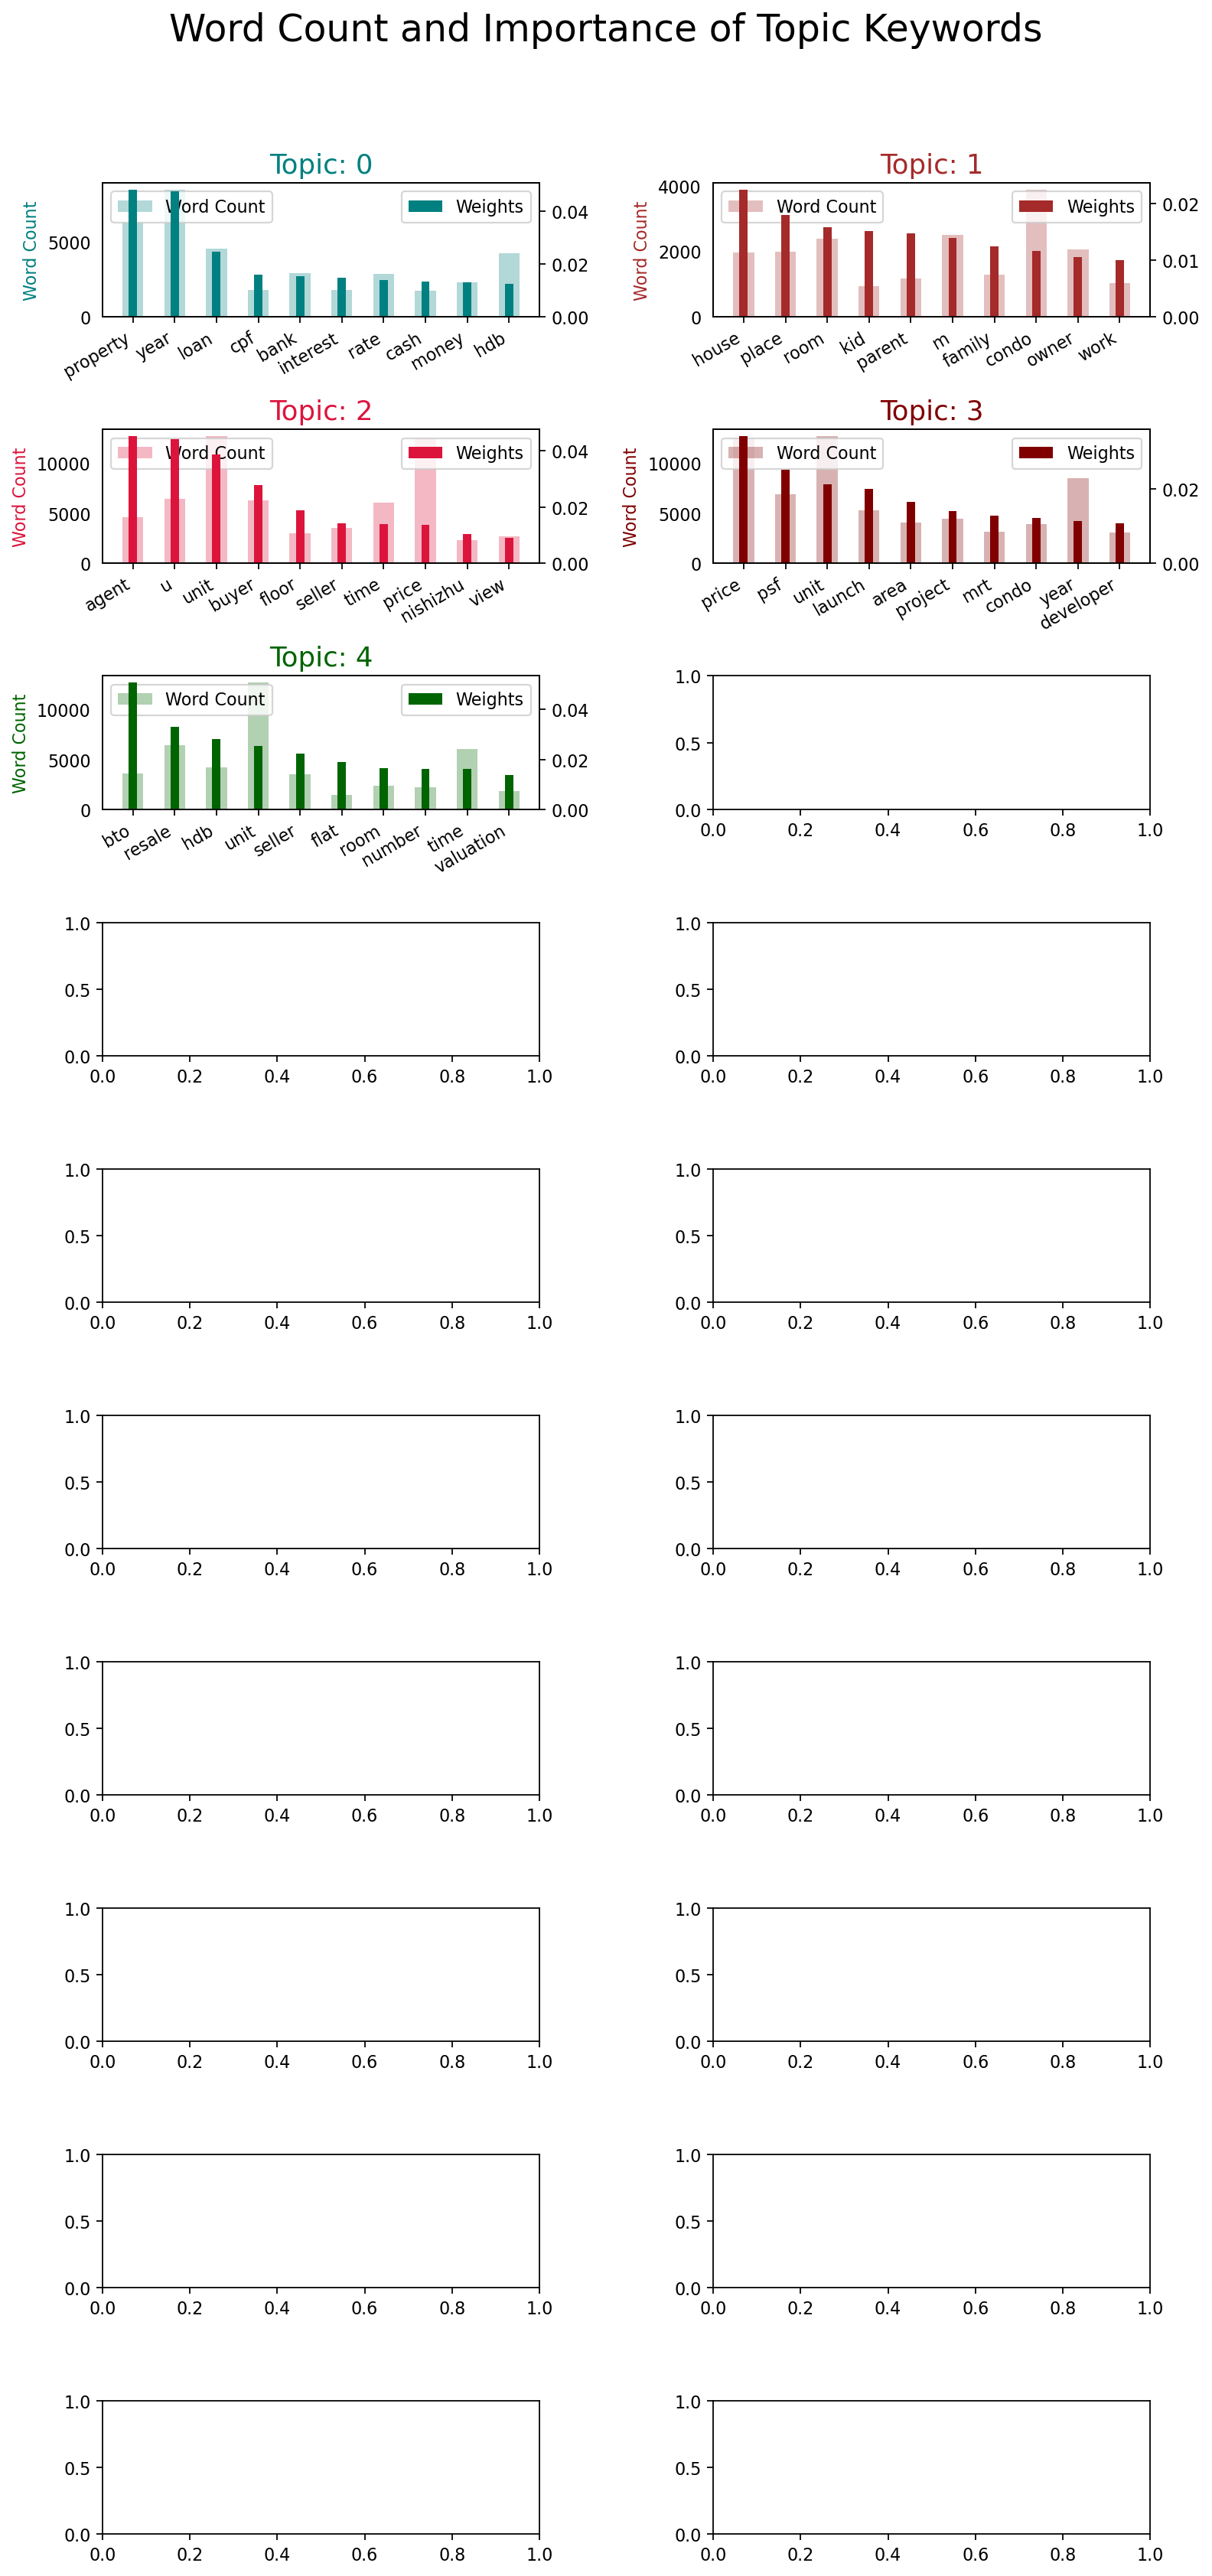

In [34]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(10, 2, figsize=(10,20), dpi=160)
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()